<a href="https://colab.research.google.com/github/sachinkun21/CNN_Architectures/blob/master/ResNet50_Mask_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Jul  8 16:53:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Loading Dataset

In [ ]:
data_dir =  '/content/drive/My Drive/DataScience/face-mask-detector/dataset/'

In [ ]:
from imutils import paths
import os

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
image_paths = list(paths.list_images(data_dir))
print(image_paths[:2])
len(image_paths)

['/content/drive/My Drive/DataScience/face-mask-detector/dataset/with_mask/336-with-mask.jpg', '/content/drive/My Drive/DataScience/face-mask-detector/dataset/with_mask/335-with-mask.jpg']


1376

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from keras.datasets import cifar100
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.transform import resize
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

Using TensorFlow backend.


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

load_array = True
if load_array!=True:
  # global list to store Image arrays and Data
  data = []
  labels = []

  i = 0
  # loop over the image paths
  for imagePath in image_paths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    #load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    i+=1
    if i%50==0:
      print(i,end = ' ')
    data.append(image)
    labels.append(label)


  data[0],labels[0]
else:
  print('Loading from array')

Loading from array


In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

if load_array!=True:
  # convert the data and labels to NumPy arrays
  data = np.array(data, dtype="float32")
  labels = np.array(labels)

  # perform one-hot encoding on the labels
  lb = LabelBinarizer()
  labels = lb.fit_transform(labels)
  labels = to_categorical(labels)
  print(labels[:5])

### Save into array for future Use

In [ ]:
import numpy
# save numpy array as npz file
from numpy import asarray
from numpy import savez_compressed

if load_array!=True:
  # save to npy file
  savez_compressed('/content/drive/My Drive/DataScience/face-mask-detector/MaskData_X.npz', data)
  # save to npy file
  savez_compressed('/content/drive/My Drive/DataScience/face-mask-detector/NoMaskData_Y.npz', labels)

In [ ]:
# load numpy array from npz file
from numpy import load

# load dict of arrays
dict_data_X = load('/content/drive/My Drive/DataScience/face-mask-detector/MaskData_X.npz')
dict_data_Y = load('/content/drive/My Drive/DataScience/face-mask-detector/NoMaskData_Y.npz')

# extract the first array
data,labels = dict_data_X['arr_0'], dict_data_Y['arr_0']

# print the array shape
print(data.shape,labels.shape)

(1376, 224, 224, 3) (1376, 2)


In [ ]:
# Dividing data into training and testing splits using 80% to 20% ratio
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
augmentor = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
len(X_train),len(X_test)

(1100, 276)

In [ ]:
X_train[0].shape,y_train[0].shape

((224, 224, 3), (2,))

### Setting Learning ratem number of Epochs, batch_size

In [ ]:
# initialize the initial learning rate, number of epochs to train for,and batch size
init_lr = 0.001
epochs = 50
batch_size = 64

## Data Load, Augmentation and Preprocessing Code

In [ ]:
# data_dir =  '/content/drive/My Drive/DataScience/face-mask-detector/dataset/small'

In [ ]:
# train_datagen = ImageDataGenerator(rescale=1./255, shear_range = 0.2,zoom_range=0.1, horizontal_flip=True,rotation_range=20,width_shift_range=0.2, height_shift_range=0.2)
# test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# training_set = train_datagen.flow_from_directory(data_dir,batch_size = batch_size, class_mode='binary')
# test_set = test_datagen.flow_from_directory(data_dir,batch_size = batch_size, class_mode='binary')

## Model: Resnet 50

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224, 3))

# loop over all layers in the base model and freeze them so they will
# not be updated during the first training process apart from batch_norm layers
for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

headModel = resnet_model.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=resnet_model.input, outputs=headModel)

In [ ]:
# compile our model
opt = Adam(lr=init_lr, decay=init_lr / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
history = model.fit(
	augmentor.flow(X_train, y_train, batch_size=batch_size),
	steps_per_epoch=len(X_train) // batch_size,
	validation_data=(X_test, y_test),
	validation_steps=len(X_test) // batch_size,
	epochs=epochs)

Epoch 1/50
17/17 [==============================] - 12s 716ms/step - loss: 0.5626 - accuracy: 0.7925 - val_loss: 0.0329 - val_accuracy: 0.9964
Epoch 2/50
17/17 [==============================] - 11s 652ms/step - loss: 0.0795 - accuracy: 0.9681 - val_loss: 0.0459 - val_accuracy: 0.9855
Epoch 3/50
17/17 [==============================] - 11s 648ms/step - loss: 0.0400 - accuracy: 0.9846 - val_loss: 0.0274 - val_accuracy: 0.9928
Epoch 4/50
17/17 [==============================] - 11s 648ms/step - loss: 0.0286 - accuracy: 0.9894 - val_loss: 0.0135 - val_accuracy: 0.9964
Epoch 5/50
17/17 [==============================] - 11s 652ms/step - loss: 0.0123 - accuracy: 0.9961 - val_loss: 0.0102 - val_accuracy: 0.9964
Epoch 6/50
17/17 [==============================] - 11s 650ms/step - loss: 0.0171 - accuracy: 0.9932 - val_loss: 0.0212 - val_accuracy: 0.9964
Epoch 7/50
17/17 [==============================] - 11s 653ms/step - loss: 0.0100 - accuracy: 0.9971 - val_loss: 0.0097 - val_accuracy: 0.9964

In [ ]:
# serialize the model to disk
model.save('/content/drive/My Drive/DataScience/face-mask-detector/res_mask.h5', save_format="h5")

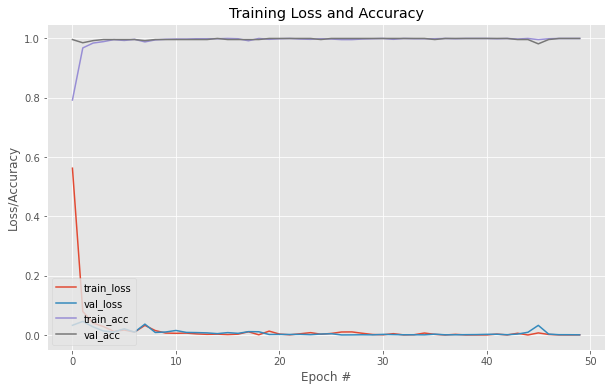

In [ ]:
# plot the training loss and accuracy
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
# make predictions on the testing set
from sklearn.metrics import classification_report

predIdxs = model.predict(X_test, batch_size=batch_size)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), predIdxs,target_names=['Mask', 'No Mask']))

              precision    recall  f1-score   support

        Mask       1.00      1.00      1.00       138
     No Mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



CheckPoint Strategy:

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
                               verbose=1, save_best_only=True)
t=time.time()

historytemp = model.fit_generator(datagen.flow(x_train, y_train,
                                  batch_size=1),
                                  steps_per_epoch=1,
                                  epochs=1,
                                  validation_data=(x_test, y_test))
print('Training time: %s' % (t - time.time()))